# Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Providing the Data

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

In [3]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [4]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [5]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset.data.shape

torch.Size([10000, 28, 28])

In [9]:
batch_size = 128

#DataLoader maps values from (0, 255) to (0, 1)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# The model

In [6]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

# Device

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

# Loss and Optimizer

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Train the model

In [10]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss, test_loss = [], []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784) # Reshape the input
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    test_loss.append(loss.item())

  train_losses[it] = np.mean(train_loss)
  test_losses[it] = np.mean(test_loss)

  print(f'Epoch {it + 1}/{n_epochs}, Train loss:{train_losses[it]:.4}, Test loss:{test_losses[it]:.4}')

Epoch 1/10, Train loss:0.4163, Test loss:0.2193
Epoch 2/10, Train loss:0.192, Test loss:0.1584
Epoch 3/10, Train loss:0.1376, Test loss:0.1223
Epoch 4/10, Train loss:0.1068, Test loss:0.1038
Epoch 5/10, Train loss:0.08716, Test loss:0.0918
Epoch 6/10, Train loss:0.07203, Test loss:0.08385
Epoch 7/10, Train loss:0.06068, Test loss:0.08767
Epoch 8/10, Train loss:0.05239, Test loss:0.07558
Epoch 9/10, Train loss:0.04337, Test loss:0.07036
Epoch 10/10, Train loss:0.03731, Test loss:0.06923


# Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')
  #print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization


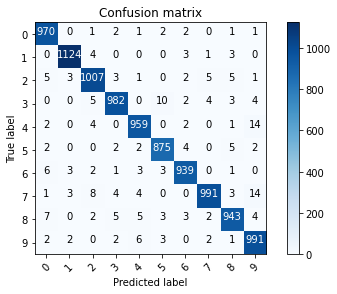

In [14]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
  inputs = inputs.to(device)
  inputs = inputs.view(-1, 784)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

# Show some Misclassified Examples

Text(0.5, 1.0, 'True label:2 Predicted:0')

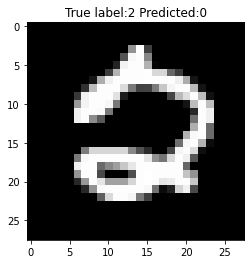

In [18]:
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title(f'True label:{y_test[i]} Predicted:{int(p_test[i])}')